In [1]:
import h5py
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# with h5py.File('data/KdV_train_1024_default.h5', 'r') as f:
#     traj_train = torch.tensor(f['train']['pde_140-256'][:], dtype=torch.float32)
# with h5py.File('data/KdV_valid_1024_default.h5', 'r') as f:
#     traj_valid = torch.tensor(f['valid']['pde_140-256'][:], dtype=torch.float32)
# with h5py.File('data/KdV_test_4096_default.h5', 'r') as f:
#     traj_test = torch.tensor(f['test']['pde_140-256'][:], dtype=torch.float32)

class args:
    equation = 'KdV'

class Traj_dataset:
    traj_train = None
    traj_valid = None
    traj_test = None

with h5py.File(f'data/{args.equation}_train_1024_default.h5', 'r') as f:
    Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:], dtype=torch.float32)[:, :131]
with h5py.File(f'data/{args.equation}_valid_1024_default.h5', 'r') as f:
    Traj_dataset.traj_valid = torch.tensor(f['valid']['pde_140-256'][:], dtype=torch.float32)[:, :131]
with h5py.File(f'data/{args.equation}_test_4096_default.h5', 'r') as f:
    Traj_dataset.traj_test = torch.tensor(f['test']['pde_140-256'][:], dtype=torch.float32)[:, :131]

In [3]:
from typing import Any, Dict, List, Tuple
import torch.nn.functional as F

class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0) if x.size()[1] > 1 else 1.0

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

def compute_metrics(y, y_pred, d=1) :
    L2_func = LpLoss(d=d, p=2, reduction=False)
    if y.shape != y_pred.shape :
        raise NotImplementedError
    l2 = L2_func.abs(y, y_pred) # [bs]
    relative_l2 = L2_func.rel(y, y_pred) # [bs]
    mse = F.mse_loss(y_pred, y, reduction='none') # [bs]
    mse = mse.mean(dim=tuple(range(1, mse.ndim)))
    return l2, relative_l2, mse


In [4]:
epochs = 500
lr = 0.001
batch_size = 32

In [6]:
import sys
sys.path.append('/mnt/home/yegonkim/.local/lib/python3.10/site-packages' )

In [8]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm


def experiment_direct(initial_datasize=256, batch_acquire=32, num_acquire=1, device='cpu', **cfg):

    def train(X_train, Y_train):
        model = FNO(n_modes=(256, ), hidden_channels=64,
                        in_channels=1, out_channels=1)

        model = model.to(device)

        model.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
        criterion = torch.nn.MSELoss()

        dataset = torch.utils.data.TensorDataset(X_train, Y_train)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()
            scheduler.step()
        
        return model

    def test(model):
        X_test = Traj_dataset.traj_test[:,0,:].unsqueeze(1)
        Y_test = Traj_dataset.traj_test[:,-1,:].unsqueeze(1)

        testset = torch.utils.data.TensorDataset(X_test, Y_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

        model.eval()
        
        Y_test_pred = []
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                Y_test_pred.append(y_pred)
            Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
        
        metrics = compute_metrics(Y_test, Y_test_pred, d=1)
        return metrics

    def select_var(ensemble, X_pool, batch_acquire):
        for model in ensemble:
            model.eval()
        with torch.no_grad():
            y_preds = [model(X_pool) for model in ensemble]
            y_preds = torch.stack(y_preds, dim=0) # [ensemble_size, pool_size, ...]
            y_preds_var = y_preds.var(dim=0) # [pool_size, ...]
            y_preds_var = y_preds_var.mean(dim=tuple(range(1, y_preds_var.ndim))) # [pool_size]
        new_idxs = torch.argsort(y_preds_var, descending=True)[:batch_acquire]
        return new_idxs

    ensemble_size = cfg.get('ensemble_size', 5)

    results = {'datasize': [], 'rel_l2': []}

    X = Traj_dataset.traj_train[:,0].unsqueeze(1)
    Y = Traj_dataset.traj_train[:,-1].unsqueeze(1)

    train_idxs = torch.arange(initial_datasize, device=device)
    pool_idxs = torch.arange(initial_datasize, X.shape[0], device=device)

    X_train = X[train_idxs]
    Y_train = Y[train_idxs]

    X_pool = X[pool_idxs]

    ensemble = [train(X_train, Y_train) for _ in range(ensemble_size)]

    results['datasize'].append(train_idxs.shape[0])
    rel_l2_list = [test(model)[1].mean().item() for model in ensemble]
    results['rel_l2'].append(rel_l2_list)

    for i in tqdm(range(num_acquire)):
        new_idxs = select_var(ensemble, X_pool, batch_acquire)

        new_idxs = new_idxs.to(device)
        # print(f'{len(new_idxs)=}')
        logical_new_idxs = torch.zeros(pool_idxs.shape[-1], dtype=torch.bool, device=device)
        logical_new_idxs[new_idxs] = True
        train_idxs = torch.cat([train_idxs, pool_idxs[logical_new_idxs]], dim=-1)
        pool_idxs = pool_idxs[~logical_new_idxs]

        X_train = X[train_idxs]
        Y_train = Y[train_idxs]

        X_pool = X[pool_idxs]

        ensemble = [train(X_train, Y_train) for _ in range(ensemble_size)]

        results['datasize'].append(train_idxs.shape[0])
        rel_l2_list = [test(model)[1].mean().item() for model in ensemble]
        results['rel_l2'].append(rel_l2_list)
    
    return results

results = experiment_direct(initial_datasize=256, batch_acquire=32, num_acquire=1, device=device)

AttributeError: module 'wandb.sdk' has no attribute 'lib'

100%|██████████| 3/3 [00:28<00:00,  9.66s/it]


0.44473329186439514


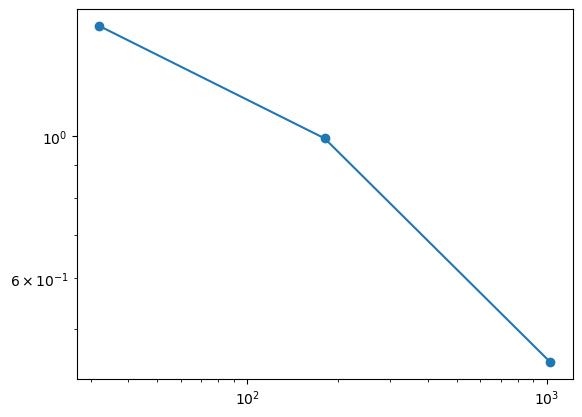

In [13]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm



def experiment_2(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=14)

    model = model.to(device)

    model.train()

    X_train = traj_train[:datasize,0].unsqueeze(1)
    Y_train = traj_train[:datasize,9::10]

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 100
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    for epoch in tqdm(range(epochs)):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        scheduler.step()


    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1:]
            Y_test_pred.append(y_pred)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

datasize_list = 2 ** np.linspace(5,10,3)
# datasize_list = [1024]
rel_l2_list = []
for datasize in tqdm(datasize_list):
    metrics = experiment_2(datasize=int(datasize), device=device)
    rel_l2_list.append(metrics[1].mean().item())
    # print(metrics)
    # loss_list.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(datasize_list, rel_l2_list, 'o-')
plt.xscale('log')
plt.yscale('log')
print(rel_l2_list)


100%|██████████| 3/3 [00:48<00:00, 16.28s/it]


0.4734871983528137


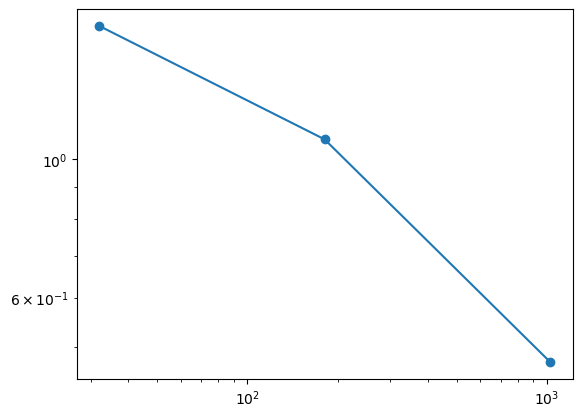

In [14]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm



def experiment_3(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=140)

    model = model.to(device)

    model.train()

    X_train = traj_train[:datasize,0].unsqueeze(1)
    Y_train = traj_train[:datasize,:]

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 100
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    for epoch in tqdm(range(epochs)):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        scheduler.step()


    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1:]
            Y_test_pred.append(y_pred)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

datasize_list = 2 ** np.linspace(5,10,3)
# datasize_list = [1024]
rel_l2_list = []
for datasize in tqdm(datasize_list):
    metrics = experiment_3(datasize=int(datasize), device=device)
    rel_l2_list.append(metrics[1].mean().item())
    # print(metrics)
    # loss_list.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(datasize_list, rel_l2_list, 'o-')
plt.xscale('log')
plt.yscale('log')
print(rel_l2_list)


100%|██████████| 4/4 [05:49<00:00, 87.44s/it] 


[1.0127394199371338, 0.7636476755142212, 0.47838324308395386, 0.2835148870944977]


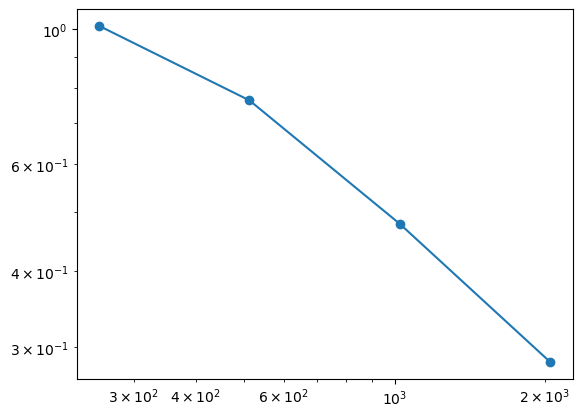

In [8]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm



def experiment_4(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=1)

    model = model.to(device)

    model.train()

    traj = torch.cat([traj_train, traj_valid], dim=0)

    X_train = traj[:datasize,0].unsqueeze(1)
    Y_train = traj[:datasize,-1].unsqueeze(1)

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 500
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    for epoch in tqdm(range(epochs)):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        scheduler.step()


    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            Y_test_pred.append(y_pred)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics


datasize_list = 2 ** np.linspace(8,11,4)
# datasize_list = [1024]
rel_l2_list = []
for datasize in tqdm(datasize_list):
    metrics = experiment_4(datasize=int(datasize), device=device)
    rel_l2_list.append(metrics[1].mean().item())
    # print(metrics)
    # loss_list.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(datasize_list, rel_l2_list, 'o-')
plt.xscale('log')
plt.yscale('log')
print(rel_l2_list)


100%|██████████| 3/3 [06:42<00:00, 134.05s/it]


0.23067039251327515


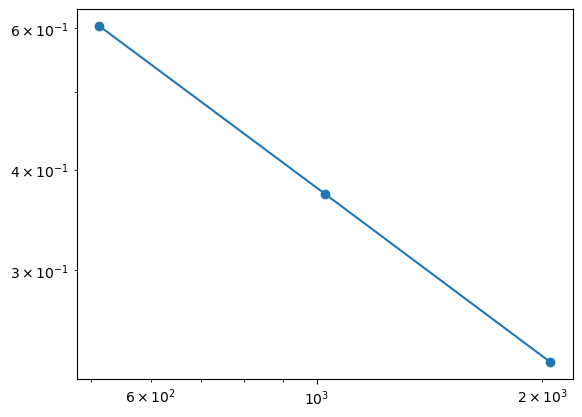

In [19]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm



def experiment_5(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=14)

    model = model.to(device)

    model.train()

    traj = torch.cat([traj_train, traj_valid], dim=0)

    X_train = traj[:datasize,0].unsqueeze(1)
    Y_train = traj[:datasize,0::10]

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 500
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    for epoch in tqdm(range(epochs)):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        scheduler.step()


    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1:]
            Y_test_pred.append(y_pred)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

datasize_list = 2 ** np.linspace(8,11,4)
# datasize_list = [1024]
rel_l2_list = []
for datasize in tqdm(datasize_list):
    metrics = experiment_5(datasize=int(datasize), device=device)
    rel_l2_list.append(metrics[1].mean().item())
    # print(metrics)
    # loss_list.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(datasize_list, rel_l2_list, 'o-')
plt.xscale('log')
plt.yscale('log')
print(rel_l2_list)


100%|██████████| 3/3 [11:16<00:00, 225.35s/it]


[0.5718531608581543, 0.3814239799976349, 0.25865742564201355]


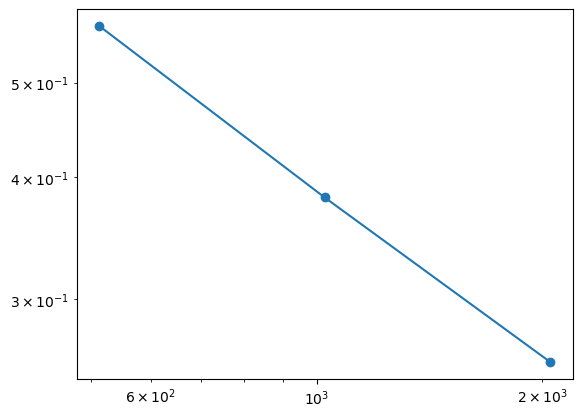

In [22]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm



def experiment_6(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=140)

    model = model.to(device)

    model.train()

    traj = torch.cat([traj_train, traj_valid], dim=0)

    X_train = traj[:datasize,0].unsqueeze(1)
    Y_train = traj[:datasize,:]

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 500
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    for epoch in tqdm(range(epochs)):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
        scheduler.step()


    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1:]
            Y_test_pred.append(y_pred)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

datasize_list = 2 ** np.linspace(8,11,4)
# datasize_list = [1024]
rel_l2_list = []
for datasize in tqdm(datasize_list):
    metrics = experiment_6(datasize=int(datasize), device=device)
    rel_l2_list.append(metrics[1].mean().item())
    # print(metrics)
    # loss_list.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(datasize_list, rel_l2_list, 'o-')
plt.xscale('log')
plt.yscale('log')
print(rel_l2_list)


In [7]:
traj_train[:,0:131:10].shape

torch.Size([1024, 14, 256])

In [29]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

class cfg:
    unrolling = 1
    nt = 14

def experiment_7(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=1)

    model = model.to(device)

    model.train()

    timestep = (traj_train.shape[1] - 1) // (cfg.nt - 1) # 10
    assert timestep == 10

    X_train = traj_train[:datasize,0].unsqueeze(1)
    Y_train = traj_train[:datasize,0::timestep]

    assert Y_train.shape[1] == cfg.nt

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 500
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        max_unrolling = epoch if epoch <= cfg.unrolling else cfg.unrolling
        unrolling = [r for r in range(max_unrolling + 1)]

        # Loop over every epoch as often as the number of timesteps in one trajectory.
        # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
        # Therefore in expectation the whole available training information is covered.
        total_loss = 0
        for i in range(cfg.nt):
            for x, y in dataloader:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device) # y has shape [bs, nt, nx]

                unrolled = random.choice(unrolling)
                bs = x.shape[0]

                steps = [t for t in range(0, cfg.nt - 1 - unrolled)]
                random_steps = random.choices(steps, k=bs)

                inputs = torch.stack([y[b, random_steps[b]] for b in range(bs)], dim=0).unsqueeze(1)
                outputs = torch.stack([y[b, random_steps[b] + unrolled+1] for b in range(bs)], dim=0).unsqueeze(1)

                # pushforward
                with torch.no_grad():
                    model.eval()
                    for _ in range(unrolled):
                        inputs = model(inputs)
                    model.train()
                
                pred = model(inputs)
                loss = criterion(pred, outputs)

                # loss = torch.sqrt(loss)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        scheduler.step()
        pbar.set_description(f'Epoch {epoch}: {total_loss}')


        if (epoch+1) % 10 == 0:    
            model.eval()
        
            Y_test_pred = []
            with torch.no_grad():
                for x, y in testloader:
                    x, y = x.to(device), y.to(device)
                    for _ in range(cfg.nt-1):
                        x = model(x)
                    Y_test_pred.append(x)
                Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
            
            metrics = compute_metrics(Y_test, Y_test_pred, d=1)
            print(f'Epoch {epoch}: {metrics[1].mean().item()}')

    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            for _ in range(cfg.nt-1):
                x = model(x)
            Y_test_pred.append(x)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

metrics = experiment_7(datasize=int(1024), device=device)
print(metrics[1].mean().item())

# # datasize_list = 2 ** np.linspace(8,11,4)
# datasize_list = [1024]
# rel_l2_list = []
# for datasize in tqdm(datasize_list):
#     metrics = experiment_7(datasize=int(datasize), device=device)
#     rel_l2_list.append(metrics[1].mean().item())
#     # print(metrics)
#     # loss_list.append(loss.item())

# import matplotlib.pyplot as plt
# plt.plot(datasize_list, rel_l2_list, 'o-')
# plt.xscale('log')
# plt.yscale('log')
# print(rel_l2_list)


Epoch 9: 2.0591709805303253:   2%|▏         | 10/500 [00:43<41:11,  5.04s/it]

Epoch 9: 0.7579634785652161


Epoch 19: 0.3156185319676297:   4%|▍         | 20/500 [01:23<40:11,  5.02s/it] 

Epoch 19: 0.5466873645782471


Epoch 29: 0.5199064172265935:   6%|▌         | 30/500 [02:07<40:19,  5.15s/it] 

Epoch 29: 0.2766586244106293


Epoch 39: 0.19478101060303743:   8%|▊         | 40/500 [02:46<35:12,  4.59s/it]

Epoch 39: 0.3599174916744232


Epoch 49: 0.1356526488052623:  10%|█         | 50/500 [03:27<37:37,  5.02s/it] 

Epoch 49: 0.38581717014312744


Epoch 59: 0.4026398817732115:  12%|█▏        | 60/500 [04:11<37:50,  5.16s/it] 

Epoch 59: 0.2643512189388275


Epoch 69: 0.1782258454240946:  14%|█▍        | 70/500 [04:55<36:50,  5.14s/it] 

Epoch 69: 0.18178319931030273


Epoch 79: 0.07954608312320488:  16%|█▌        | 80/500 [05:39<35:54,  5.13s/it]

Epoch 79: 0.4568058252334595


Epoch 89: 0.07858873851728276:  18%|█▊        | 90/500 [06:23<35:01,  5.13s/it] 

Epoch 89: 0.41509443521499634


Epoch 99: 0.09744475696243171:  20%|██        | 100/500 [07:07<33:54,  5.09s/it]

Epoch 99: 0.1802845150232315


Epoch 109: 0.03731080873421888:  22%|██▏       | 110/500 [07:51<33:28,  5.15s/it] 

Epoch 109: 0.27548447251319885


Epoch 119: 0.07656706913803646:  24%|██▍       | 120/500 [08:35<32:19,  5.10s/it] 

Epoch 119: 0.6386719346046448


Epoch 129: 0.05073275834274682:  26%|██▌       | 130/500 [09:18<30:35,  4.96s/it] 

Epoch 129: 0.2506380081176758


Epoch 139: 0.053517557475970534:  28%|██▊       | 140/500 [10:01<30:25,  5.07s/it]

Epoch 139: 0.30343449115753174


Epoch 149: 0.06709585263888584:  30%|███       | 150/500 [10:45<29:47,  5.11s/it] 

Epoch 149: 0.5397531390190125


Epoch 159: 0.023199682712856884:  32%|███▏      | 160/500 [11:29<28:43,  5.07s/it]

Epoch 159: 0.14454127848148346


Epoch 169: 0.05735197776721179:  34%|███▍      | 170/500 [12:12<27:40,  5.03s/it] 

Epoch 169: 0.31258416175842285


Epoch 179: 0.01908025953161996:  36%|███▌      | 180/500 [12:55<26:48,  5.03s/it] 

Epoch 179: 0.13889393210411072


Epoch 189: 0.020667927333761327:  38%|███▊      | 190/500 [13:34<24:11,  4.68s/it]

Epoch 189: 0.11461084336042404


Epoch 199: 0.07221269286947063:  40%|████      | 200/500 [14:14<23:16,  4.66s/it] 

Epoch 199: 0.36562520265579224


Epoch 209: 0.057666580959448765:  42%|████▏     | 210/500 [14:56<24:34,  5.08s/it]

Epoch 209: 0.27368786931037903


Epoch 219: 0.013999611895997077:  44%|████▍     | 220/500 [15:41<24:08,  5.17s/it]

Epoch 219: 0.16459375619888306


Epoch 229: 0.018484945112959394:  46%|████▌     | 230/500 [16:25<23:12,  5.16s/it]

Epoch 229: 0.6343560814857483


Epoch 239: 0.015117064532660152:  48%|████▊     | 240/500 [17:10<22:30,  5.19s/it]

Epoch 239: 0.25413089990615845


Epoch 249: 0.006837870011395353:  50%|█████     | 250/500 [17:54<21:24,  5.14s/it]

Epoch 249: 0.11753278970718384


Epoch 259: 0.00877984603312143:  52%|█████▏    | 260/500 [18:38<20:42,  5.18s/it] 

Epoch 259: 0.21633771061897278


Epoch 269: 0.026070999091871272:  54%|█████▍    | 270/500 [19:19<19:24,  5.06s/it]

Epoch 269: 0.1411091387271881


Epoch 279: 0.020867956518486608:  56%|█████▌    | 280/500 [20:02<18:53,  5.15s/it] 

Epoch 279: 0.11288626492023468


Epoch 289: 0.015557481531232042:  58%|█████▊    | 290/500 [20:46<17:51,  5.10s/it]

Epoch 289: 0.446380615234375


Epoch 299: 0.01497660199947859:  60%|██████    | 300/500 [21:29<17:08,  5.14s/it]  

Epoch 299: 0.19533300399780273


Epoch 309: 0.009937010310295591:  62%|██████▏   | 310/500 [22:11<16:09,  5.10s/it] 

Epoch 309: 0.17461900413036346


Epoch 319: 0.0020533458699674156:  64%|██████▍   | 320/500 [22:50<13:55,  4.64s/it]

Epoch 319: 0.11243234574794769


Epoch 329: 0.008187936552985775:  66%|██████▌   | 330/500 [23:30<13:13,  4.67s/it] 

Epoch 329: 0.08151792734861374


Epoch 339: 0.0030435481391464236:  68%|██████▊   | 340/500 [24:10<12:26,  4.67s/it]

Epoch 339: 0.16115525364875793


Epoch 349: 0.00144538815152373:  70%|███████   | 350/500 [24:52<12:40,  5.07s/it]  

Epoch 349: 0.1203872412443161


Epoch 359: 0.002787992940852746:  72%|███████▏  | 360/500 [25:34<10:58,  4.70s/it] 

Epoch 359: 0.08712530881166458


Epoch 369: 0.0013832834162599283:  74%|███████▍  | 370/500 [26:13<10:03,  4.64s/it]

Epoch 369: 0.08541268110275269


Epoch 379: 0.001579507817666581:  76%|███████▌  | 380/500 [26:53<09:59,  4.99s/it] 

Epoch 379: 0.087444968521595


Epoch 389: 0.0012147648577069958:  78%|███████▊  | 390/500 [27:33<08:35,  4.68s/it]

Epoch 389: 0.08667729794979095


Epoch 399: 0.0012444753492957261:  80%|████████  | 400/500 [28:15<08:25,  5.06s/it]

Epoch 399: 0.09512484073638916


Epoch 409: 0.0010255148461340013:  82%|████████▏ | 410/500 [28:56<07:00,  4.67s/it]

Epoch 409: 0.07517120242118835


Epoch 419: 0.0009179858008678821:  84%|████████▍ | 420/500 [29:36<06:24,  4.81s/it]

Epoch 419: 0.07248620688915253


Epoch 429: 0.0005815887593314528:  86%|████████▌ | 430/500 [30:20<05:57,  5.11s/it]

Epoch 429: 0.07531760632991791


Epoch 439: 0.0004868874470105311:  88%|████████▊ | 440/500 [31:00<04:57,  4.95s/it]

Epoch 439: 0.09402938932180405


Epoch 449: 0.00044383790768165454:  90%|█████████ | 450/500 [31:44<04:16,  5.14s/it]

Epoch 449: 0.07451662421226501


Epoch 459: 0.0003884953999317986:  92%|█████████▏| 460/500 [32:23<03:04,  4.61s/it] 

Epoch 459: 0.07096677273511887


Epoch 469: 0.00036716862027219577:  94%|█████████▍| 470/500 [33:02<02:17,  4.60s/it]

Epoch 469: 0.07096024602651596


Epoch 479: 0.00035278042375352925:  96%|█████████▌| 480/500 [33:44<01:42,  5.11s/it]

Epoch 479: 0.06995964795351028


Epoch 489: 0.000353349114931234:  98%|█████████▊| 490/500 [34:29<00:52,  5.22s/it]  

Epoch 489: 0.07269006222486496


Epoch 499: 0.0003529877427297379: 100%|██████████| 500/500 [35:14<00:00,  4.23s/it] 

Epoch 499: 0.06975848972797394


0.06975848972797394


In [35]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

class cfg:
    unrolling = 0
    nt = 14

def experiment_7(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=1)

    model = model.to(device)

    model.train()

    timestep = (traj_train.shape[1] - 1) // (cfg.nt - 1) # 10
    assert timestep == 10

    X_train = traj_train[:datasize,0].unsqueeze(1)
    Y_train = traj_train[:datasize,0::timestep]

    assert Y_train.shape[1] == cfg.nt

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 500
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        max_unrolling = epoch if epoch <= cfg.unrolling else cfg.unrolling
        unrolling = [r for r in range(max_unrolling + 1)]

        # Loop over every epoch as often as the number of timesteps in one trajectory.
        # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
        # Therefore in expectation the whole available training information is covered.
        total_loss = 0
        for i in range(cfg.nt):
            for x, y in dataloader:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device) # y has shape [bs, nt, nx]

                unrolled = random.choice(unrolling)
                bs = x.shape[0]

                steps = [t for t in range(0, cfg.nt - 1 - unrolled)]
                random_steps = random.choices(steps, k=bs)

                inputs = torch.stack([y[b, random_steps[b]] for b in range(bs)], dim=0).unsqueeze(1)
                outputs = torch.stack([y[b, random_steps[b] + unrolled+1] for b in range(bs)], dim=0).unsqueeze(1)

                # pushforward
                with torch.no_grad():
                    model.eval()
                    for _ in range(unrolled):
                        inputs = model(inputs)
                    model.train()
                
                pred = model(inputs)
                loss = criterion(pred, outputs)

                # loss = torch.sqrt(loss)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        scheduler.step()
        pbar.set_description(f'Epoch {epoch}: {total_loss}')


        if (epoch+1) % 100 == 0:    
            model.eval()
        
            Y_test_pred = []
            with torch.no_grad():
                for x, y in testloader:
                    x, y = x.to(device), y.to(device)
                    for _ in range(cfg.nt-1):
                        x = model(x)
                    Y_test_pred.append(x)
                Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
            
            metrics = compute_metrics(Y_test, Y_test_pred, d=1)
            print(f'Epoch {epoch}: {metrics[1].mean().item()}')

    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            for _ in range(cfg.nt-1):
                x = model(x)
            Y_test_pred.append(x)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

metrics = experiment_7(datasize=int(128), device=device)
print(metrics[1].mean().item())

# # datasize_list = 2 ** np.linspace(8,11,4)
# datasize_list = [1024]
# rel_l2_list = []
# for datasize in tqdm(datasize_list):
#     metrics = experiment_7(datasize=int(datasize), device=device)
#     rel_l2_list.append(metrics[1].mean().item())
#     # print(metrics)
#     # loss_list.append(loss.item())

# import matplotlib.pyplot as plt
# plt.plot(datasize_list, rel_l2_list, 'o-')
# plt.xscale('log')
# plt.yscale('log')
# print(rel_l2_list)


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 99: 0.03580907318973914:  20%|██        | 100/500 [00:47<10:01,  1.50s/it]

Epoch 99: 0.743078351020813


Epoch 199: 0.02266362914815545:  40%|████      | 200/500 [01:33<07:30,  1.50s/it]  

Epoch 199: 0.35807880759239197


Epoch 299: 0.0019802354645435116:  60%|██████    | 300/500 [02:20<04:56,  1.48s/it]

Epoch 299: 0.25653505325317383


Epoch 399: 0.00010032965451500786:  80%|████████  | 400/500 [03:08<02:29,  1.49s/it]

Epoch 399: 0.15289203822612762


Epoch 499: 5.328673097437786e-05: 100%|██████████| 500/500 [03:56<00:00,  2.12it/s] 

Epoch 499: 0.12587201595306396


0.12587201595306396


Epoch 0: 8.275171692832373:   0%|          | 1/500 [00:05<44:46,  5.38s/it]


KeyboardInterrupt: 

In [36]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

class cfg:
    unrolling = 1
    nt = 14

def experiment_7(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=1)

    model = model.to(device)

    model.train()

    timestep = (traj_train.shape[1] - 1) // (cfg.nt - 1) # 10
    assert timestep == 10

    X_train = traj_train[:datasize,0].unsqueeze(1)
    Y_train = traj_train[:datasize,0::timestep]

    assert Y_train.shape[1] == cfg.nt

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 500
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        max_unrolling = epoch if epoch <= cfg.unrolling else cfg.unrolling
        unrolling = [r for r in range(max_unrolling + 1)]

        # Loop over every epoch as often as the number of timesteps in one trajectory.
        # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
        # Therefore in expectation the whole available training information is covered.
        total_loss = 0
        for i in range(cfg.nt):
            for x, y in dataloader:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device) # y has shape [bs, nt, nx]

                unrolled = random.choice(unrolling)
                bs = x.shape[0]

                steps = [t for t in range(0, cfg.nt - 1 - unrolled)]
                random_steps = random.choices(steps, k=bs)

                inputs = torch.stack([y[b, random_steps[b]] for b in range(bs)], dim=0).unsqueeze(1)
                outputs = torch.stack([y[b, random_steps[b] + unrolled+1] for b in range(bs)], dim=0).unsqueeze(1)

                # pushforward
                with torch.no_grad():
                    model.eval()
                    for _ in range(unrolled):
                        inputs = model(inputs)
                    model.train()
                
                pred = model(inputs)
                loss = criterion(pred, outputs)

                # loss = torch.sqrt(loss)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        scheduler.step()
        pbar.set_description(f'Epoch {epoch}: {total_loss}')


        if (epoch+1) % 100 == 0:    
            model.eval()
        
            Y_test_pred = []
            with torch.no_grad():
                for x, y in testloader:
                    x, y = x.to(device), y.to(device)
                    for _ in range(cfg.nt-1):
                        x = model(x)
                    Y_test_pred.append(x)
                Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
            
            metrics = compute_metrics(Y_test, Y_test_pred, d=1)
            print(f'Epoch {epoch}: {metrics[1].mean().item()}')

    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            for _ in range(cfg.nt-1):
                x = model(x)
            Y_test_pred.append(x)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

metrics = experiment_7(datasize=int(128), device=device)
print(metrics[1].mean().item())

# # datasize_list = 2 ** np.linspace(8,11,4)
# datasize_list = [1024]
# rel_l2_list = []
# for datasize in tqdm(datasize_list):
#     metrics = experiment_7(datasize=int(datasize), device=device)
#     rel_l2_list.append(metrics[1].mean().item())
#     # print(metrics)
#     # loss_list.append(loss.item())

# import matplotlib.pyplot as plt
# plt.plot(datasize_list, rel_l2_list, 'o-')
# plt.xscale('log')
# plt.yscale('log')
# print(rel_l2_list)


Epoch 99: 0.052730042225448415:  20%|██        | 100/500 [00:52<10:36,  1.59s/it]

Epoch 99: 0.6809247732162476


Epoch 199: 0.013361447556235362:  40%|████      | 200/500 [01:45<07:41,  1.54s/it] 

Epoch 199: 0.6291029453277588


Epoch 299: 0.0014892618428348214:  60%|██████    | 300/500 [02:38<05:10,  1.55s/it]

Epoch 299: 0.3856046497821808


Epoch 399: 0.00037118823911441723:  80%|████████  | 400/500 [03:30<02:29,  1.49s/it]

Epoch 399: 0.33926084637641907


Epoch 499: 0.00019136279775011644: 100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

Epoch 499: 0.3321656584739685


0.3321656584739685


In [37]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

class cfg:
    unrolling = 0
    nt = 14

def experiment_7(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=1)

    model = model.to(device)

    model.train()

    timestep = (traj_train.shape[1] - 1) // (cfg.nt - 1) # 10
    assert timestep == 10

    X_train = traj_train[:datasize,0].unsqueeze(1)
    Y_train = traj_train[:datasize,0::timestep]

    assert Y_train.shape[1] == cfg.nt

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 500
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        max_unrolling = epoch if epoch <= cfg.unrolling else cfg.unrolling
        unrolling = [r for r in range(max_unrolling + 1)]

        # Loop over every epoch as often as the number of timesteps in one trajectory.
        # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
        # Therefore in expectation the whole available training information is covered.
        total_loss = 0
        for i in range(cfg.nt):
            for x, y in dataloader:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device) # y has shape [bs, nt, nx]

                unrolled = random.choice(unrolling)
                bs = x.shape[0]

                steps = [t for t in range(0, cfg.nt - 1 - unrolled)]
                random_steps = random.choices(steps, k=bs)

                inputs = torch.stack([y[b, random_steps[b]] for b in range(bs)], dim=0).unsqueeze(1)
                outputs = torch.stack([y[b, random_steps[b] + unrolled+1] for b in range(bs)], dim=0).unsqueeze(1)

                # pushforward
                with torch.no_grad():
                    model.eval()
                    for _ in range(unrolled):
                        inputs = model(inputs)
                    model.train()
                
                pred = model(inputs)
                loss = criterion(pred, outputs)

                # loss = torch.sqrt(loss)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        scheduler.step()
        pbar.set_description(f'Epoch {epoch}: {total_loss}')


        if (epoch+1) % 100 == 0:    
            model.eval()
        
            Y_test_pred = []
            with torch.no_grad():
                for x, y in testloader:
                    x, y = x.to(device), y.to(device)
                    for _ in range(cfg.nt-1):
                        x = model(x)
                    Y_test_pred.append(x)
                Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
            
            metrics = compute_metrics(Y_test, Y_test_pred, d=1)
            print(f'Epoch {epoch}: {metrics[1].mean().item()}')

    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            for _ in range(cfg.nt-1):
                x = model(x)
            Y_test_pred.append(x)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

metrics = experiment_7(datasize=int(1024), device=device)
print(metrics[1].mean().item())

# # datasize_list = 2 ** np.linspace(8,11,4)
# datasize_list = [1024]
# rel_l2_list = []
# for datasize in tqdm(datasize_list):
#     metrics = experiment_7(datasize=int(datasize), device=device)
#     rel_l2_list.append(metrics[1].mean().item())
#     # print(metrics)
#     # loss_list.append(loss.item())

# import matplotlib.pyplot as plt
# plt.plot(datasize_list, rel_l2_list, 'o-')
# plt.xscale('log')
# plt.yscale('log')
# print(rel_l2_list)


Epoch 99: 0.03297178119282762:  20%|██        | 100/500 [05:36<29:52,  4.48s/it]

Epoch 99: 0.32939431071281433


Epoch 199: 0.005080248587546521:  40%|████      | 200/500 [11:48<30:41,  6.14s/it] 

Epoch 199: 0.19090096652507782


Epoch 299: 0.0009965568253278434:  60%|██████    | 300/500 [17:48<15:30,  4.65s/it]

Epoch 299: 0.06757449358701706


Epoch 399: 0.00018807791974495558:  80%|████████  | 400/500 [23:40<07:48,  4.68s/it]

Epoch 399: 0.06641793251037598


Epoch 499: 7.316759043618504e-05: 100%|██████████| 500/500 [29:47<00:00,  3.58s/it] 

Epoch 499: 0.018813734874129295


0.018813734874129295


In [38]:
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

class cfg:
    unrolling = 1
    nt = 14

def experiment_7(datasize=1024, device='cpu'):

    model = FNO(n_modes=(256, ), hidden_channels=64,
                    in_channels=1, out_channels=1)

    model = model.to(device)

    model.train()

    timestep = (traj_train.shape[1] - 1) // (cfg.nt - 1) # 10
    assert timestep == 10

    X_train = traj_train[:datasize,0].unsqueeze(1)
    Y_train = traj_train[:datasize,0::timestep]

    assert Y_train.shape[1] == cfg.nt

    X_test = traj_test[:,0,:].unsqueeze(1)
    Y_test = traj_test[:,-1,:].unsqueeze(1)


    epochs = 500
    lr = 0.001
    bs = 32
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

    testset = torch.utils.data.TensorDataset(X_test, Y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        max_unrolling = epoch if epoch <= cfg.unrolling else cfg.unrolling
        unrolling = [r for r in range(max_unrolling + 1)]

        # Loop over every epoch as often as the number of timesteps in one trajectory.
        # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
        # Therefore in expectation the whole available training information is covered.
        total_loss = 0
        for i in range(cfg.nt):
            for x, y in dataloader:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device) # y has shape [bs, nt, nx]

                unrolled = random.choice(unrolling)
                bs = x.shape[0]

                steps = [t for t in range(0, cfg.nt - 1 - unrolled)]
                random_steps = random.choices(steps, k=bs)

                inputs = torch.stack([y[b, random_steps[b]] for b in range(bs)], dim=0).unsqueeze(1)
                outputs = torch.stack([y[b, random_steps[b] + unrolled+1] for b in range(bs)], dim=0).unsqueeze(1)

                # pushforward
                with torch.no_grad():
                    model.eval()
                    for _ in range(unrolled):
                        inputs = model(inputs)
                    model.train()
                
                pred = model(inputs)
                loss = criterion(pred, outputs)

                # loss = torch.sqrt(loss)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        scheduler.step()
        pbar.set_description(f'Epoch {epoch}: {total_loss}')


        if (epoch+1) % 100 == 0:    
            model.eval()
        
            Y_test_pred = []
            with torch.no_grad():
                for x, y in testloader:
                    x, y = x.to(device), y.to(device)
                    for _ in range(cfg.nt-1):
                        x = model(x)
                    Y_test_pred.append(x)
                Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
            
            metrics = compute_metrics(Y_test, Y_test_pred, d=1)
            print(f'Epoch {epoch}: {metrics[1].mean().item()}')

    model.eval()
    
    Y_test_pred = []
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            for _ in range(cfg.nt-1):
                x = model(x)
            Y_test_pred.append(x)
        Y_test_pred = torch.cat(Y_test_pred, dim=0).to(Y_test.device)
    
    metrics = compute_metrics(Y_test, Y_test_pred, d=1)

    return metrics

metrics = experiment_7(datasize=int(1024), device=device)
print(metrics[1].mean().item())

# # datasize_list = 2 ** np.linspace(8,11,4)
# datasize_list = [1024]
# rel_l2_list = []
# for datasize in tqdm(datasize_list):
#     metrics = experiment_7(datasize=int(datasize), device=device)
#     rel_l2_list.append(metrics[1].mean().item())
#     # print(metrics)
#     # loss_list.append(loss.item())

# import matplotlib.pyplot as plt
# plt.plot(datasize_list, rel_l2_list, 'o-')
# plt.xscale('log')
# plt.yscale('log')
# print(rel_l2_list)


Epoch 99: 0.11482645213436626:  20%|██        | 100/500 [06:42<34:41,  5.20s/it]

Epoch 99: 0.3163425028324127


Epoch 199: 0.043258798490114714:  40%|████      | 200/500 [13:37<25:53,  5.18s/it]

Epoch 199: 0.28844961524009705


Epoch 299: 0.01570138475085514:  60%|██████    | 300/500 [20:22<17:07,  5.14s/it]  

Epoch 299: 0.10947953164577484


Epoch 399: 0.002701114028525353:  80%|████████  | 400/500 [27:16<08:42,  5.22s/it] 

Epoch 399: 0.08543503284454346


Epoch 499: 0.0003726458682251632: 100%|██████████| 500/500 [34:08<00:00,  4.10s/it] 

Epoch 499: 0.07151971757411957


0.07151971757411957
